In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import intake

In [2]:
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

In [26]:
# Global attributes are described in https://docs.google.com/document/d/1h0r8RZr_f3-8egBMMh7aqLwy3snpD6_MrDz1q8n5XUk/edit

# Variables are described in this spreadsheet
# http://proj.badc.rl.ac.uk/svn/exarch/CMIP6dreq/tags/latest/dreqPy/docs/CMIP6_MIP_tables.xlsx
variable_id = 'tas' # Surface Air Temperature
table_id = 'Amon' # Monthly data from Atmosphere

grid = 'gn' #

# Records for Institution, experiment, and source_id are stored in https://github.com/WCRP-CMIP/CMIP6_CVs
experiment_ids = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
activity_ids = ['ScenarioMIP', 'CMIP'] # Search Scenarios & Historical data only
institution_id = 'NASA-GISS'
source_id = ['GISS-E2-1-G']

# Member ID is formed from subexperiment id & variant label
# variant label is
# variant_label: a label constructed from 4 indices stored as global attributes:  
# variant_label = r<k>i<l>p<m>f<n>
#       where
# k = realization_index
# l = initialization_index
# m = physics_index
# n = forcing_index
# For a given experiment, the realization_index, initialization_index, physics_index, and forcing_index are used to uniquely identify each simulation of an ensemble of runs contributed by a single model.

member_id = 'r1i1p3f1'

In [27]:
res = catalog.search(activity_id=activity_ids, institution_id=institution_id, experiment_id=experiment_ids, source_id=source_id, table_id=table_id, variable_id=variable_id, grid_label=grid, member_id=member_id)
display(res.df)

/home/ec2-user/anaconda3/envs/daskpy3/lib/python3.7/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version


In [28]:
datasets = res.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True})

/home/ec2-user/anaconda3/envs/daskpy3/lib/python3.7/site-packages/intake_esm/core.py:890: UserWarning: There are no datasets to load! Returning an empty dictionary.
  warn('There are no datasets to load! Returning an empty dictionary.')


In [29]:
display(datasets)

{}

In [7]:
# Put the air temperature into units that we understand better

for i in datasets:
    ds = datasets[i]
    if ds.tas.units == 'K':
        ds.tas.values = (ds.tas.values - 273.15) * 9.0 / 5.0 + 32.0
        ds['tas', 'units'] = 'F'

In [8]:
display(datasets['ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp126.Amon.gn'])

<xarray.Dataset>
Dimensions:           (bnds: 2, lat: 90, lon: 144, member_id: 1, time: 1032)
Coordinates:
    height            float64 ...
  * lat               (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
    lat_bnds          (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
  * lon               (lon) float64 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
    lon_bnds          (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * time              (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds         (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * member_id         (member_id) <U8 'r1i1p3f1'
Dimensions without coordinates: bnds
Data variables:
    tas               (member_id, time, lat, lon) float32 -18.59 ... -9.801
    ('tas', 'units')  <U1 'F'
Attributes: (12/53)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    cmor_version:            3.3.2
    ...                      ...
    variable_id:             tas
    variant_label:           r1i1p3f1
    netcdf_tracking_ids:     hdl:21.14100/72e1e6f8-c5d1-4285-921f-ab81401252d...
    version_id:              v20200115
    intake_esm_varname:      ['tas']
    intake_esm_dataset_key:  ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp126.Amon.gn

In [9]:
# Lets look at how the air temperature changed over the period of this simulation. We will extract the air temperature at the end from the air temperature at the beginning
# We take an average over the last twelve months minus the first twelve months to even out seasonality

# Lets look at SSP585, one of the more extreme emissions scenarios where little is done to curb greenhouse gas emissions

tas = datasets['ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp585.Amon.gn']['tas'].isel(time=np.arange(1032-12,1032)).mean(dim='time') - datasets['ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp585.Amon.gn']['tas'].isel(time=np.arange(0,12)).mean(dim='time')
tas.compute()

<xarray.DataArray 'tas' (member_id: 1, lat: 90, lon: 144)>
array([[[ 8.7257805,  8.7257805,  8.7257805, ...,  8.7257805,
          8.7257805,  8.7257805],
        [ 7.5220375,  7.460861 ,  8.147896 , ...,  7.875351 ,
          8.324631 ,  7.898533 ],
        [ 7.8663864,  7.6960907,  8.095661 , ...,  6.9713097,
          7.5036964,  7.894127 ],
        ...,
        [13.47014  , 13.332699 , 13.085119 , ..., 14.248704 ,
         14.045583 , 13.7976675],
        [13.723781 , 13.6747465, 13.654558 , ..., 14.016148 ,
         13.923458 , 13.776283 ],
        [14.215809 , 14.215809 , 14.215809 , ..., 14.215809 ,
         14.215809 , 14.215809 ]]], dtype=float32)
Coordinates:
    height     float64 2.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member_id  (member_id) <U8 'r1i1p3f1'

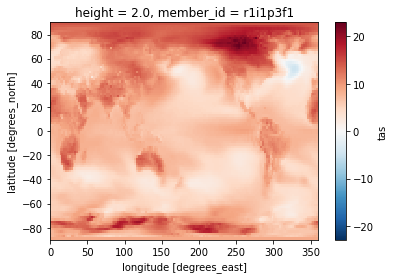

In [10]:
tas.plot()

In [11]:
# Compute the mean of the differences
mean_difference = tas.mean().compute()

In [12]:
mean_difference

<xarray.DataArray 'tas' ()>
array(8.126888, dtype=float32)
Coordinates:
    height   float64 2.0

In [13]:
# That shows that on average Earth warms 8 F over the next 100 years in the SSP585 scenario according to the NASA GISS model!

In [22]:
# We can also look at how the temperature evolves over a single location for all of the scenarios too.
# Here we will look at Colorado Springs

location_name = 'Colorado Springs'
location_lon = -104.82
location_lat = 38.83

# convert to 0-360 for longitudes
if location_lon < 0:
     location_lon = 360 + location_lon

In [23]:
ds_scenarios = xr.Dataset()


# interate through the locations and create a dataset
# containing the temperature values for each location
for i in datasets:
    ds = datasets[i]

    ds2 = ds.sel(lon=location_lon, lat=location_lat, method='nearest')
    ds2 = ds2.rename({'tas' : i}).drop(('lat', 'lon', 'height', 'lat_bnds', 'lon_bnds', 'time_bnds', 'member_id'))
    ds_scenarios = xr.merge([ds_scenarios, ds2], compat='override')

ds_scenarios

<xarray.Dataset>
Dimensions:                                           (member_id: 1, time: 3012)
Coordinates:
  * time                                              (time) object 1850-01-1...
Dimensions without coordinates: member_id
Data variables:
    CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon.gn     (member_id, time) float32 ...
    ('tas', 'units')                                  <U1 'F'
    ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp585.Amon.gn  (member_id, time) float32 ...
    ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp126.Amon.gn  (member_id, time) float32 ...
    ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp245.Amon.gn  (member_id, time) float32 ...
    ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp370.Amon.gn  (member_id, time) float32 ...

In [24]:
# Compute the extraction of points and get them into a dataframe
df_f = ds_scenarios.to_dataframe()
df_f.describe()

,CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon.gn,ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp585.Amon.gn,ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp126.Amon.gn,ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp245.Amon.gn,ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp370.Amon.gn
count,1980.000000,1032.000000,1032.000000,1032.000000,1032.000000
mean,50.481350,56.429333,54.320847,54.670521,55.567814
std,17.083851,18.733564,17.760897,18.030851,18.147505
min,17.100286,24.288807,23.459339,17.731342,20.571692
25%,34.650837,38.736763,37.438919,37.466412,38.507408
50%,49.329117,55.102242,53.725243,53.735107,55.053162
75%,67.013054,74.381668,71.752480,72.313545,73.257935
max,82.487946,92.229523,87.206024,86.336349,93.018997


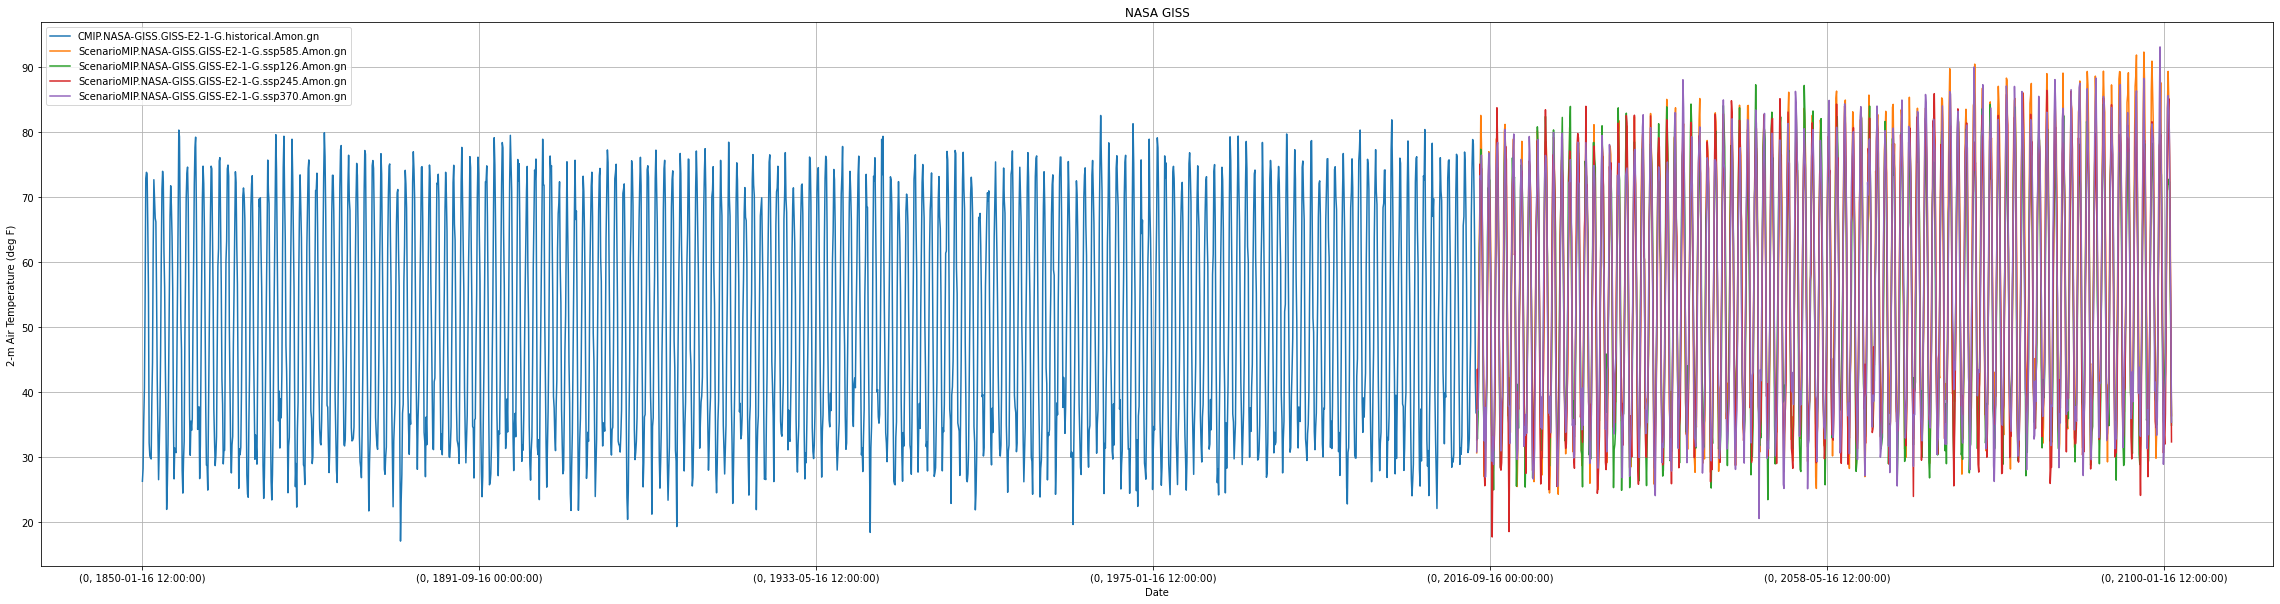

In [25]:
# Lets make a time series plot here so we can see the results.

ax = df_f.plot(figsize=(40, 10), title="NASA GISS", grid=1)
ax.set(xlabel='Date', ylabel='2-m Air Temperature (deg F)')
plt.show()